In [ ]:
!pip install flask

In [ ]:
!pip install tensorflow==2.5.0

In [ ]:
!pip install --upgrade tensorflow 

In [ ]:
!python -m pip install -U pillow
!python -m pip install -U albumentations
!python -m pip install -U segmentation-models
!python -m pip install azureml-sdk[notebooks]
!pip install azureml-contrib-services
!pip install opencv-python

In [1]:
# -*- coding: utf-8 -*-
import flask
from flask import Flask, render_template, jsonify
from azureml.core import Workspace, Datastore, Dataset
import tempfile, os, glob, re
import json 
import requests
from PIL import Image
import numpy as np

In [2]:
# List of packages
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import os, uuid
#import azureml.core

from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient, __version__
from azureml.core import Workspace, Dataset, Datastore

import random

import albumentations as A

import segmentation_models as sm

from P8_01_GenerateurData_class import GenerateurData
from P8_01_GenerateurDatasasansaug_class import GenerateurDatasansaug

import warnings
warnings.filterwarnings("ignore")

Segmentation Models: using `tf.keras` framework.


Using TensorFlow backend.


In [3]:
print(tf.keras.__version__)

2.5.0


## APP.PY API FLASK

In [4]:
%%writefile app.py


from flask import Flask, request, Response
from flask import jsonify
from skimage.transform import resize
import jsonpickle
import numpy as np
from numpy import asarray
import cv2
import PIL
from io import BytesIO
from PIL import Image


# manipulate files
import io
import os 
import json
import requests
import numpy as np
import os, glob, re, tempfile
import requests, json
import cv2
import albumentations as A
import tensorflow as tf
from tensorflow import keras
from albumentations import Compose
from albumentations import ToFloat
import segmentation_models as sm
sm.set_framework('tf.keras')
from azureml.core.model import Model
from azureml.core import Workspace, Datastore, Dataset

from azureml.contrib.services.aml_request import AMLRequest, rawhttp
from azureml.contrib.services.aml_response import AMLResponse
from azureml.core import Workspace
from azureml.core.model import Model

#map category to its color
def cat2color(arr_to_convert):
    prediction_color = {0:[0, 0, 0],            # void
                        1:[128, 64,128],       # flat
                        2:[150,100,100],         # construction
                        3:[220,220,  0],      # object
                        4:[107,142, 35],       # nature
                        5:[70, 130, 180],       # sky
                        6:[220, 20, 60],        # human
                        7:[119, 11, 32]}          # vehicule
    arr = np.zeros((*arr_to_convert.shape, 3))
    for k, v in prediction_color.items():
        arr[arr_to_convert==k] = v
    arr = arr.astype('uint8')
    return arr




ws = Workspace.from_config(path="config.json")
model = Model(ws, 'model8lp3', version=1)
# AzureML stuff to consider, checks for the registered models.
from azureml.core.model import Model 

app = Flask(__name__)

#model = tf.keras.models.load_model("model8lp3s.h5")
# Model
ARCHITECTURE = 'Unet'
BACKBONE = 'resnet34'
BATCH_SIZE = 8
LR = 0.001
EPOCHS = 5
DIM = (256, 256)
N_CLASSES = 8
N_CHANNELS = 3
ACTIVATION = 'softmax'
LOSS = 'DICE' 
CLASS_WEIGHTS = None


#metrics = [sm.metrics.IOUScore(class_weights=CLASS_WEIGHTS), sm.metrics.FScore(class_weights=CLASS_WEIGHTS)]
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
opt = keras.optimizers.Adam(learning_rate=LR)
    
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
#loss = sm.losses.DiceLoss(class_weights=CLASS_WEIGHTS)
loss = tf.keras.losses.CategoricalCrossentropy()
#model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze=False, input_shape=(256, 256, 3), classes=N_CLASSES, activation=ACTIVATION)
#model.compile(optimizer=opt, loss=loss, metrics=metrics)   
model = sm.Unet(input_shape=(256,256,3), classes=N_CLASSES, activation=ACTIVATION)
model.compile(optimizer=opt, loss=loss, metrics=metrics)


# route http posts to this method
@app.route("/", methods=['POST'])
def test():
          # preprocessing function
    def get_preprocessing(preprocessing_fn):   
        _transform = [
            A.Lambda(image=preprocessing_fn),
        ]
        return A.Compose(_transform)     
    
    
    data = request.json
    image = data['image'] 
    data = asarray(image)  
    #temp_raw = resize(image, (256, 256))
          # Predict
    aug = Compose([
            #A.HorizontalFlip(p=0.5),              
            #A.OpticalDistortion(distort_limit=2, shift_limit=0.9, p=0.5),
        A.RandomContrast(limit=0.5, p=1)
        ]
    )
    
    augmented = aug(image=data)
    preprocess_input = sm.get_preprocessing(BACKBONE)
    preprocessing=get_preprocessing(preprocess_input)
    sample = preprocessing(image=augmented['image'])


    print('>>>>>>>>>>>>>>>>>>>>>> 5')

    prediction = model.predict(sample['image'].reshape(1, *sample['image'].shape))
        #prediction = model.predict(temp_raw)

    print('>>>>>>>>>>>>>>>>>>>>>> 6')

    prediction_array = prediction[0].argmax(2)
    
        
    # convert string of image data to uint8
    #nparr = np.fromstring(r.data, np.uint8)
    # decode image
    #img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    
    
    # do some fancy processing here....
    #img = cv2.imencode('.png', img)
    
    ##response_pickled = jsonpickle.encode(prediction)

    ##return Response(response=response_pickled, status=200, mimetype="application/json")
    #response = {'status': 'ok', 'image': image}
    #return jsonify(response(json.dumps(prediction_array.tolist()), 200)
    
    return AMLResponse(json.dumps(prediction_array.tolist()), 200)

# start flask app
app.run(host="0.0.0.0", port=5000)

Overwriting app.py


## Requête POST API FLASK

In [5]:
import requests
from PIL import Image
import numpy as np
from skimage.transform import resize


ENDPOINT_URL = 'http://localhost:5000'

image = np.asarray(Image.open('frankfurt_000000_002196_leftImg8bit.png'))
image = resize(image, (256, 256))
data = { 'image': image.tolist() }

response = requests.post(ENDPOINT_URL, json = data)
response.raise_for_status()
print(response)
response

<Response [200]>


<Response [200]>

In [6]:
response.json

<bound method Response.json of <Response [200]>>

In [7]:
response.text

'[[5, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 5, 5, 6, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 5, 6, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3, 3, 6, 5, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 5, 5, 5, 6, 6, 6, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 6, 6, 6, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 5, 3, 5, 5, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 6, 6, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 6, 5, 5, 5, 5, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 6, 6, 6, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], [5, 1, 1, 1, 6, 1, 6, 3, 1, 6, 6, 3, 1, 1, 0, 1, 0, 6, 6, 0, 1, 1, 1, 6, 3, 3, 3, 6, 3, 3, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 6, 6, 6, 1, 6, 6, 1, 6, 3, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [8]:
#map category to its color
def cat2color(arr_to_convert):
    prediction_color = {0:[0, 0, 0],            # void
                        1:[128, 64,128],       # flat
                        2:[150,100,100],         # construction
                        3:[220,220,  0],      # object
                        4:[107,142, 35],       # nature
                        5:[70, 130, 180],       # sky
                        6:[220, 20, 60],        # human
                        7:[119, 11, 32]}          # vehicule
    arr = np.zeros((*arr_to_convert.shape, 3))
    for k, v in prediction_color.items():
        arr[arr_to_convert==k] = v
    arr = arr.astype('uint8')
    return arr

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [9]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [10]:
prediction_array = np.array(response.json())
prediction_array_colored = cat2color(prediction_array)

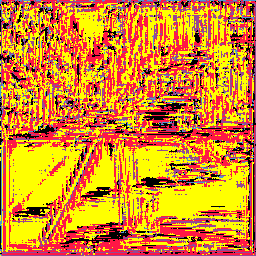

In [11]:
tf.keras.preprocessing.image.array_to_img(prediction_array_colored)

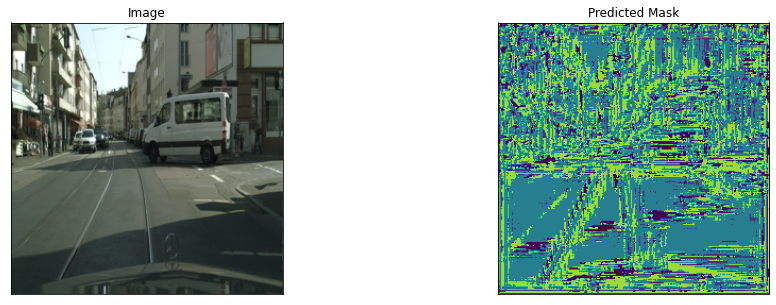

In [12]:
visualize(image = image , predicted_mask=prediction_array)

In [13]:
import requests
from PIL import Image
import numpy as np
from skimage.transform import resize


ENDPOINT_URL = 'http://localhost:5000'

image = np.asarray(Image.open('aachen_000000_000019_leftImg8bit.png'))
image = resize(image, (256, 256))
data = { 'image': image.tolist() }

response = requests.post(ENDPOINT_URL, json = data)
response.raise_for_status()
print(response)
response

<Response [200]>


<Response [200]>

In [14]:
response.text

'[[5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 3, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 6, 6, 5, 5, 6, 5, 5, 5, 6, 6, 5, 6, 6, 6, 6, 6, 6, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 6, 6, 6, 6, 6, 5, 6, 6], [0, 1, 1, 6, 6, 1, 1, 1, 1, 3, 1, 1, 1, 1, 6, 0, 1, 6, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 3, 6, 6, 6, 6, 0, 0, 0, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 4, 6, 6, 0, 6, 6, 6, 6, 6,

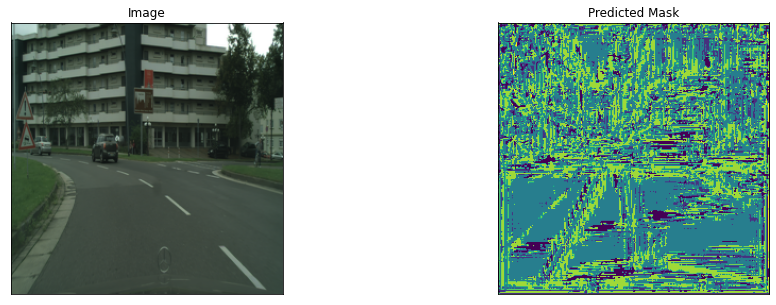

In [15]:
visualize(image = image , predicted_mask=prediction_array)